### Adversarial Patch Creation
Developed by Tal Erez <br> <br>
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/notthattal/AdversarialAI_Patch/blob/main/adversarial_patch.ipynb#scrollTo=jv7U4G4FodQf)


### Step 1: Install the required dependencies:

In [2]:
!pip install torch torchvision adversarial-robustness-toolbox matplotlib pytorch-lightning ipywidgets tabulate

You should consider upgrading via the '/Users/talerez/Documents/AIPI_590_XAI/AdversarialAI_Patch/venv/bin/python3 -m pip install --upgrade pip' command.


### Step 2: Import the required packages

In [3]:
from IPython.display import display, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pytorch_lightning as pl
import tabulate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.utils.data as data
from tqdm.notebook import tqdm
import urllib.request
from urllib.error import HTTPError
import zipfile

### Step 3: Create Environment Variables

In [4]:
# Path to the folder where the datasets should be downloaded
DATASET_PATH = "./data"

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/"

# set environment variable TORCH_HOME to the checkpoint path
os.environ["TORCH_HOME"] = CHECKPOINT_PATH

### Step 4: Set the Seed, ensure operations are deterministic on the GPU and set the device

In [5]:
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.use_deterministic_algorithms(True)
device = None

# Fetching the device that will be used throughout this notebook
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print("Using device", device)

Seed set to 42


Using device mps


### Step 5: Download the dataset

In [6]:
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"

# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH + "images/", exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
file_name = "TinyImageNet.zip"
file_path = os.path.join(DATASET_PATH, file_name)
if not os.path.isfile(file_path):
    file_url = base_url + file_name
    print(f"Downloading {file_url}...")
    try:
        urllib.request.urlretrieve(file_url, file_path)
    except HTTPError as e:
        print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
    if file_name.endswith(".zip"):
        print("Unzipping file...")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(file_path.rsplit("/",1)[0])

### Step 6: Load the Model

In [7]:
# Load a pre-trained ResNet-34 model with ImageNet weights
pretrained_model = models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# Set model to evaluation mode
pretrained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Step 6: Load the Dataset and Label Names
  - set the transform
  - load the dataset using the created transform and create the data loader
  - load the label names 

In [8]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# Convert the input image to PyTorch Tensor and normalize the images using the mean and standard deviation above
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

### Step 8: Map patch values to ImageNet min and max
  - Convert the NORM_MEAN and NORM_STD to PyTorch tensors
  - Create a function "patch_forward" which converts the patch values from [-∞,∞] to ImageNet's [min, max]

In [9]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

### Step 9: Create function which modifies the image for training
  - Places the patch in a random location in the image
  - If training the patch, will apply a random rotation for robustness

In [10]:
def place_patch(img, patch, training=False):
    for i in range(img.shape[0]):
        # Apply random rotation to the patch (e.g., between 0 and 360 degrees)
        final_patch = patch
        if training:
            angle = np.random.uniform(0, 360)
            final_patch = TF.rotate(patch, angle)

            scale = np.random.uniform(0.5, 1)
            new_size = [int(final_patch.shape[1] * scale), int(final_patch.shape[2] * scale)]
            final_patch = TF.resize(final_patch, new_size)

        h_offset = np.random.randint(0,img.shape[2]-final_patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-final_patch.shape[2]-1)
        img[i,:,h_offset:h_offset+final_patch.shape[1],w_offset:w_offset+final_patch.shape[2]] = patch_forward(final_patch)
    return img

### Step 10: Create function to evaluate the model
  - Create a function that validates the effectiveness of the patch in fooling the model into predicting the target class
  - The function excludes images in the target class
  - Averages performance among 4 random placements and returns the accuracy metrics

In [11]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4): 
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

### Step 11: Attack the Image
  - Creates a function "patch_attack" which is used to train a model to create a patch that fools a model into predicting a specific target class
  - Trains it over a specified number of epochs and evaluates the patch effectiveness on a validation set

In [12]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.9, weight_decay=0.01)
    loss_module = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch, True)
            img = img.to(device).to(next(model.parameters()).dtype)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
    
    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc.item(), "top5": top5.item()}

### Step 12: Load the evaluation results of the patches
  - Create a patch_results.json file
  - save the new patch results to the json file

In [13]:
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)
        
# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t 
                                   for t in patch_dict[cname][psize]["results"]] 
                           for psize in patch_dict[cname]} 
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

### Step 13: Get the patch/patches
  - Main training function for the model
  - for each target class we want to generate a patch for, and for each patch size we want to generate, we train the model

In [14]:
def get_patches(class_names, patch_sizes, num_epochs=5):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
           
            # Delete patch if pretrained file exists
            if os.path.isfile(file_name):
                os.remove(file_name)

            # Start training
            patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=num_epochs)
            print(f"Validation results for {name} and {patch_size}:", val_results)
            torch.save(patch, file_name)

            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)    
            
            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }
        
    return result_dict

### Step 14: Start Training
  - Set the target classes for which to create patches
  - Set the patch sizes to be trained
  - Start the training loop

In [15]:
class_names = ["bulbul"]
patch_sizes = [64]

patch_dict = get_patches(class_names, patch_sizes, num_epochs=10)

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for bulbul and 64: {'acc': 0.7304999828338623, 'top5': 0.8865000009536743}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

### Step 15: Display the patch/patches
  - Create a plot for every patch created
  - Display each plot

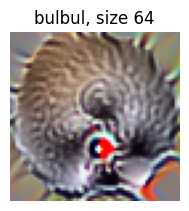

In [107]:
def show_patches(class_name, patch_size):
    fig, ax = plt.subplots(figsize=(2.2, 2.2))
    patch = patch_dict[class_name][patch_size]["patch"]
    patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
    patch = patch.cpu().permute(1, 2, 0).numpy()
    patch = np.clip(patch, a_min=0.0, a_max=1.0)
    ax.imshow(patch)
    ax.set_title(f"{class_name}, size {patch_size}")
    ax.axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

for size in patch_sizes:
    for name in class_names:
        show_patches(name, size)

### Step 16: Create HTML code to set the font size for the following table

In [108]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

### Step 17: Display Patch Attack Performance
  - Set the font size for the table
  - Generate a table showing patch_attack performance 

In [109]:
def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

show_table(top_1=False)

Class name,Patch size 64x64
bulbul,86.88%


### Step 18: Visualize the predictions
  - Create a plot for a specified number of images
  - display the image with the embedded patch
  - show a bar graph with the model's top predictions 

In [110]:
def show_prediction(img, label, pred, index, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    save_path = CHECKPOINT_PATH + "/images/" + str(index) + ".jpg"
    if save_path is not None:
        img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Convert from [0,1] to [0,255] and uint8
        img_pil.save(save_path, format='JPEG')
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

### Step 19: Retrieve input data and labels from data_loader

In [111]:
exmp_batch, label_batch = next(iter(data_loader))

### Step 20: Predict and display predictions for a specified number of examples

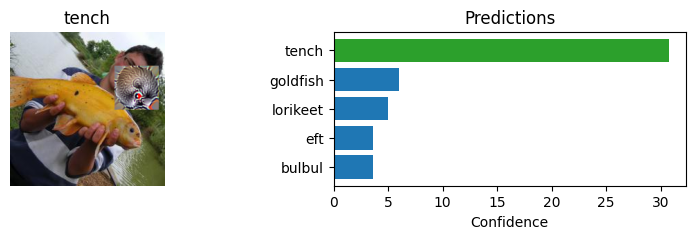

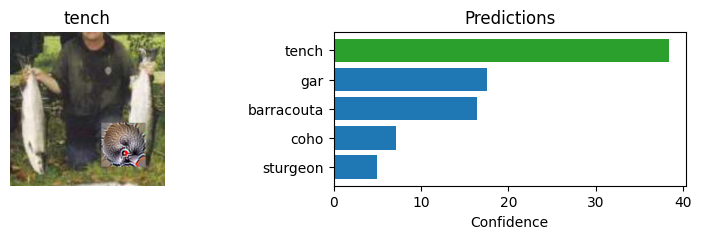

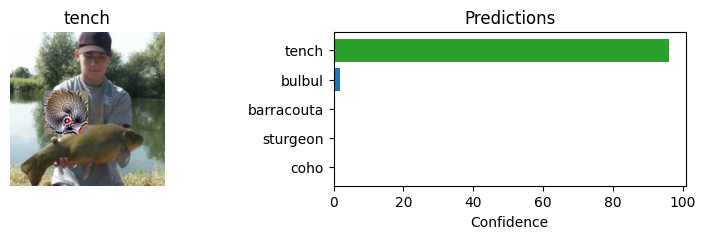

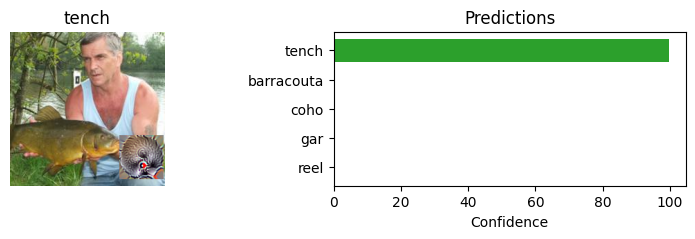

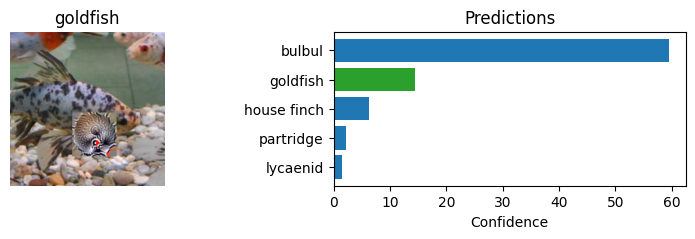

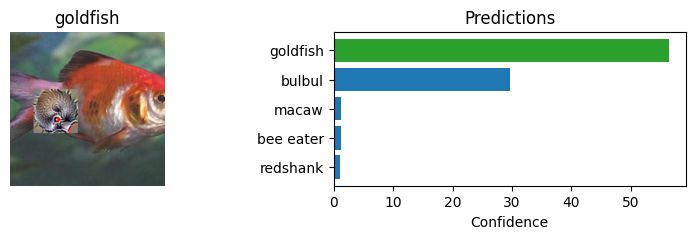

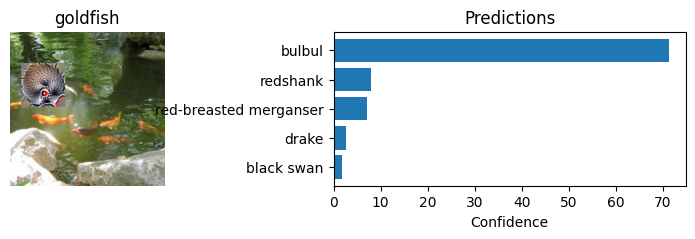

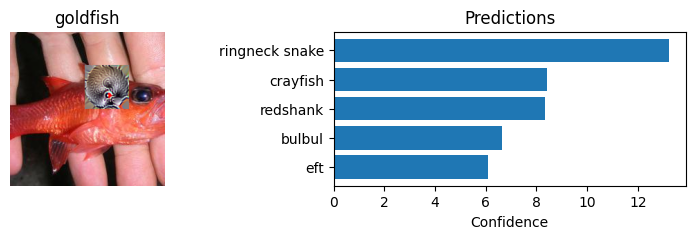

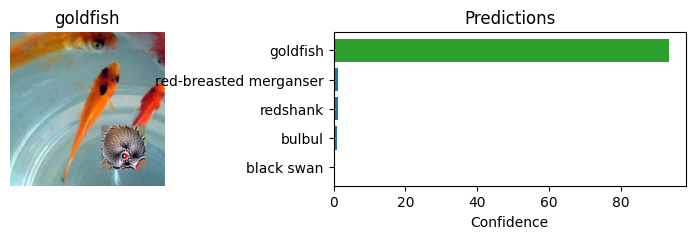

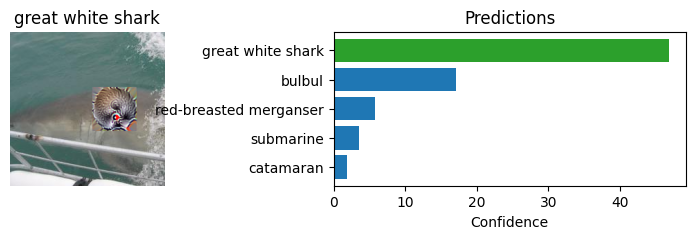

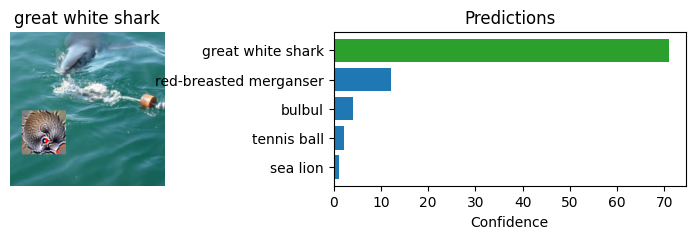

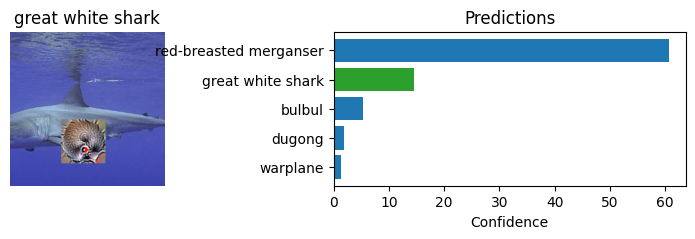

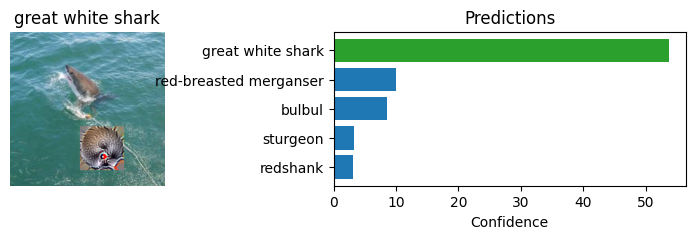

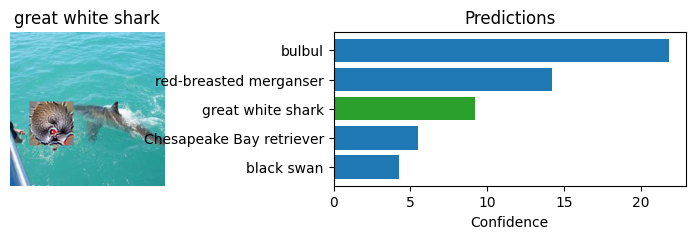

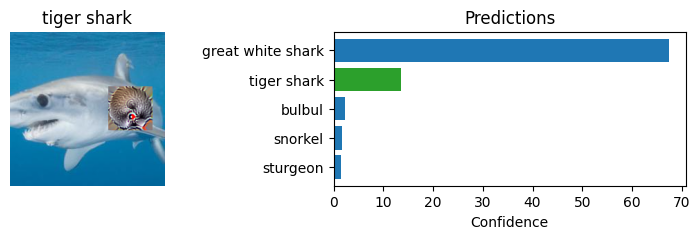

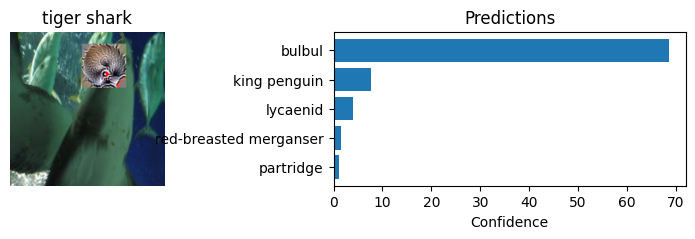

In [112]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i], i)

perform_patch_attack(patch_dict['bulbul'][64]['patch'])